In [1]:
# library 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import skfda.preprocessing.smoothing.kernel_smoothers as ks
from scipy.interpolate import interp1d
from sklearn.cluster import KMeans
from skfda import FDataGrid
from tqdm import tqdm
import matplotlib
from sklearn.decomposition import PCA

import sys
sys.path.append('./funs') 
from bw import *
from generative_model import *
from miscellaneous import *
from plot import *
sys.path.pop()

# random.seed(41)
random.seed(0)

# McCann's interpolation

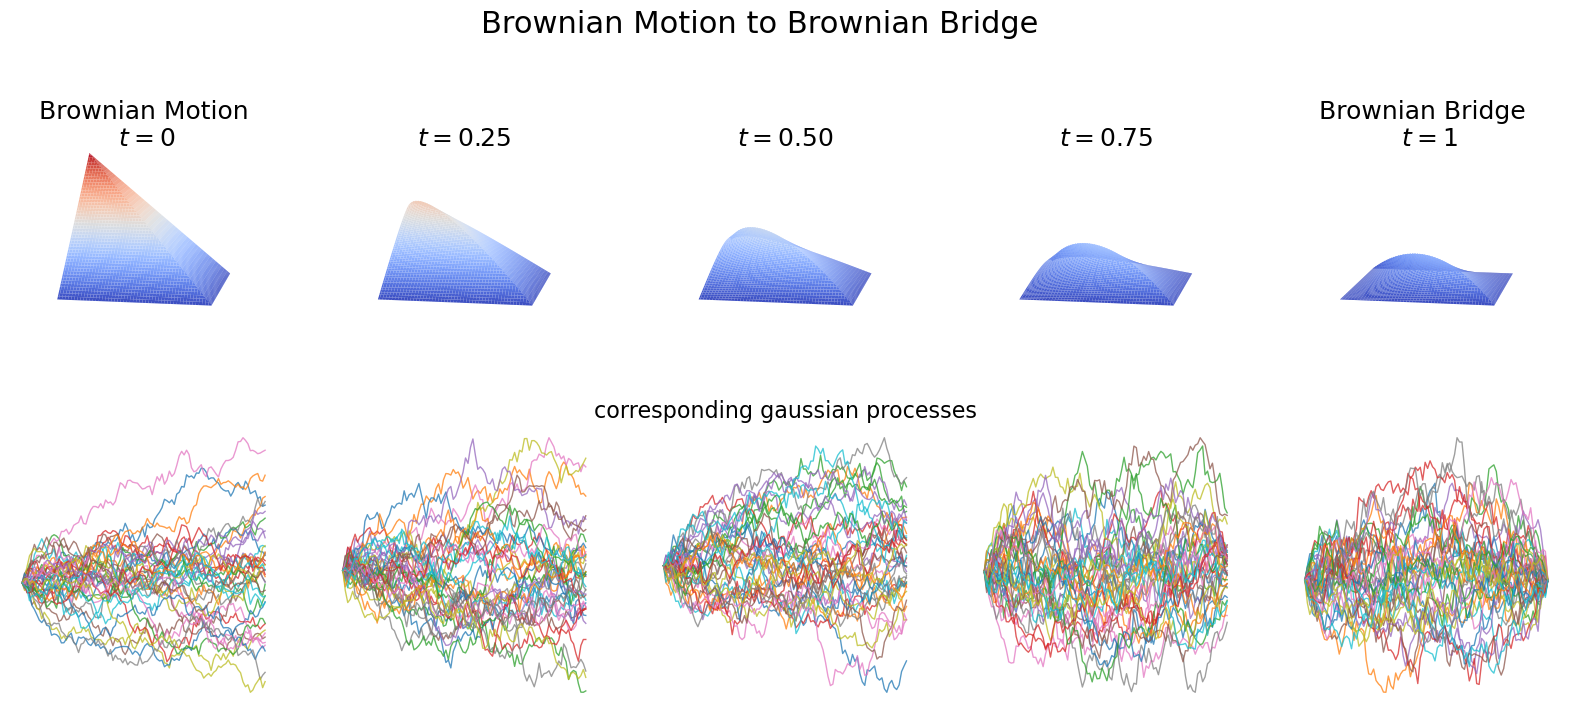

In [2]:
# set dimension 
d = 100;
# for visualisation
tgrid_plot = 5;

# generate McCann's interpolation
start =BM_cov(d); end = BB_cov(d); X = np.array([ McCann(start, end)(t) for t in np.linspace(0,1,tgrid_plot)])

# plot 3d flow and gorrespondin gaussian processes
fig = plotFlow_3d_GP(X,tgrid_plot); fig.savefig("out/mccann.png"); plt.show() 

# Generative model

100%|█████████████████████████████████████████████| 4/4 [00:08<00:00,  2.19s/it]


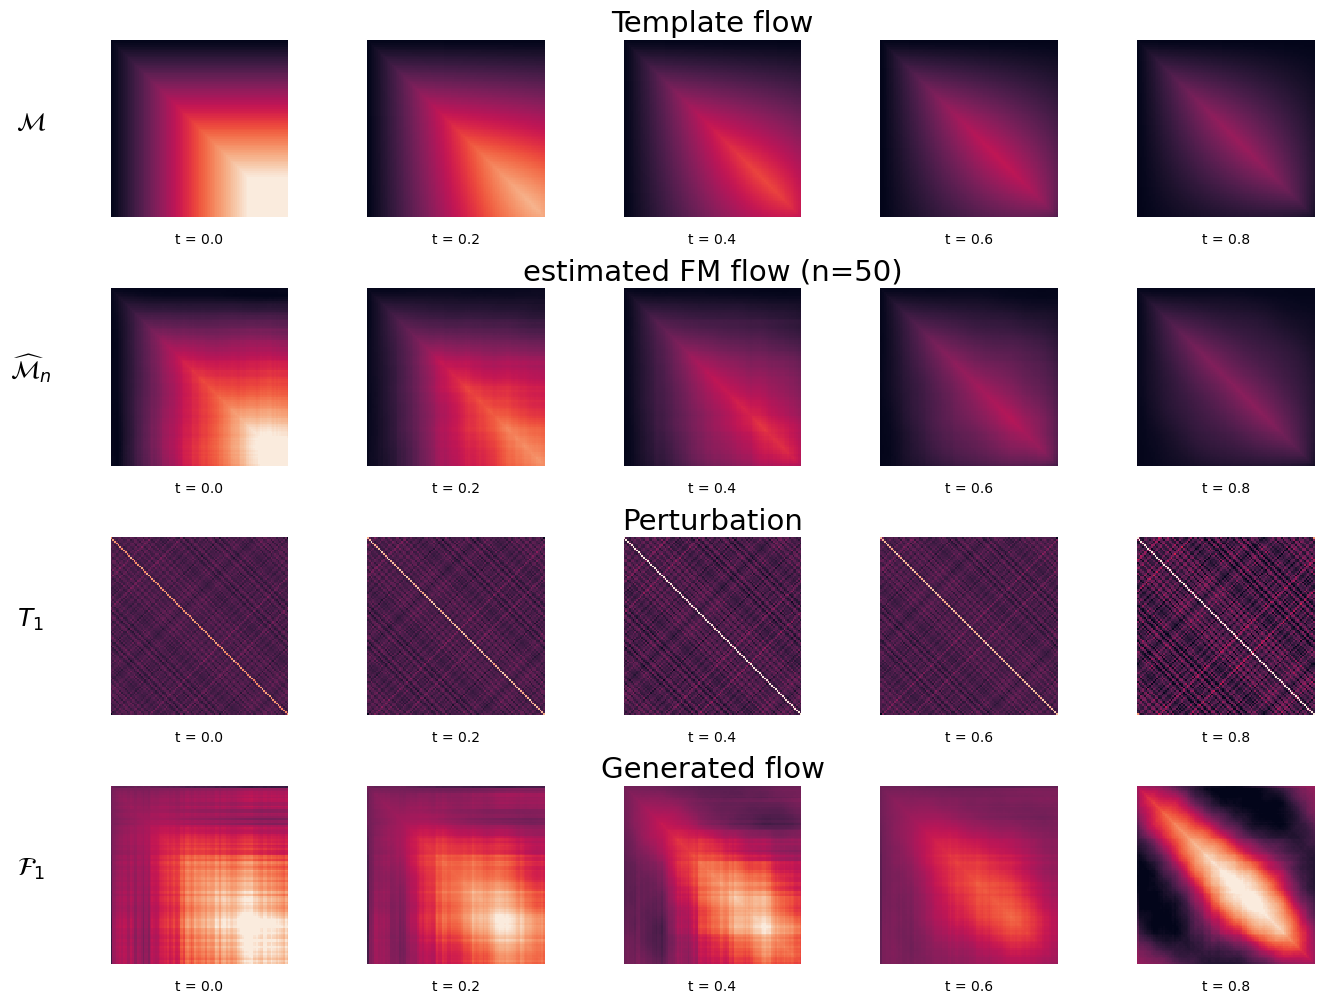

In [3]:
# dimension on Hilbert space -- corresponds to discretisation of eigenfunctions
d = 100; 

# cutoff for Mercer's expansion
cutoff = d//2

# time discretisation of unit interval
N = 11; time_grid = np.linspace(0,1,N)

# number of samples
n = 50

tgrid_plot = 5

cov0 = BM_cov(d); cov1 = BB_cov(d)
# cov0 = matern_cov(d,0.2); cov1 = matern_cov(d,2)
template = np.array([McCann(cov0,cov1)(t) for t in time_grid]).real

Ts = np.array([FreqDom_GenModel_FLOW(N,d,cutoff) for i in range(n)])
Xs = np.array([ np.array([T_@template_@T_ for T_,template_ in zip(T,template) ]) for T in Ts])


# log = np.array([ np.array([optmap(template[t_ix], Xs[i,t_ix]) -  np.eye(d) for t_ix, t in enumerate(time_grid)]) for i in tqdm(np.arange(n))]).real
# _embedded_log = np.array([ np.array([ _[t_ix]@sqrtm(template[t_ix]) for t_ix, t in enumerate(time_grid)]) for _ in log ]).real

XiHAT_plot = []
for j in tqdm(np.arange(tgrid_plot+1)):
    closeix = np.argmin((time_grid-j/tgrid_plot)**2)
    XiHAT_plot.append(FM(Xs[:,closeix,:,:], MaxIter=100)[0].real)
XiHAT_plot = np.array(XiHAT_plot)

suptitles = ['Template flow', 'estimated FM flow (n={})'.format(n), 'Perturbation','Generated flow'#,'log-projection', 'embedded log-projection'
            ]
titles = ['\mathcal{M}', '\widehat\mathcal{M}_n', 'T_1','\mathcal{F}_1' #,'\log_{\mathcal{M}}\mathcal{F}_1','\mathcal{M}^{1/2}\log_{\mathcal{M}}\mathcal{F}_1'
         ]
ix = 3; Fs = [template,XiHAT_plot, Ts[ix], Xs[ix] #, log[ix], _embedded_log[ix]
             ]
fig = plotFlow_heatmaps(Fs , tgrid_plot,cmap=cmap, suptitles = suptitles, titles = titles)
# fig.savefig("out/generative_model.png");
plt.show() 

# Bimodal samples and PCA

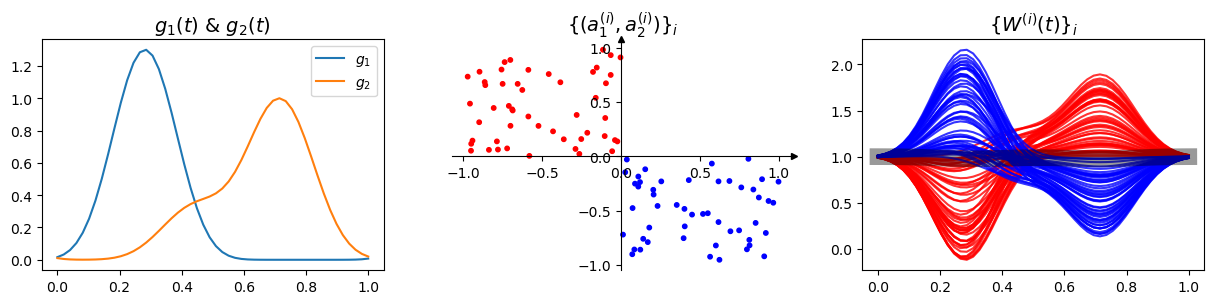

100%|█████████████████████████████████████████████| 4/4 [00:06<00:00,  1.69s/it]


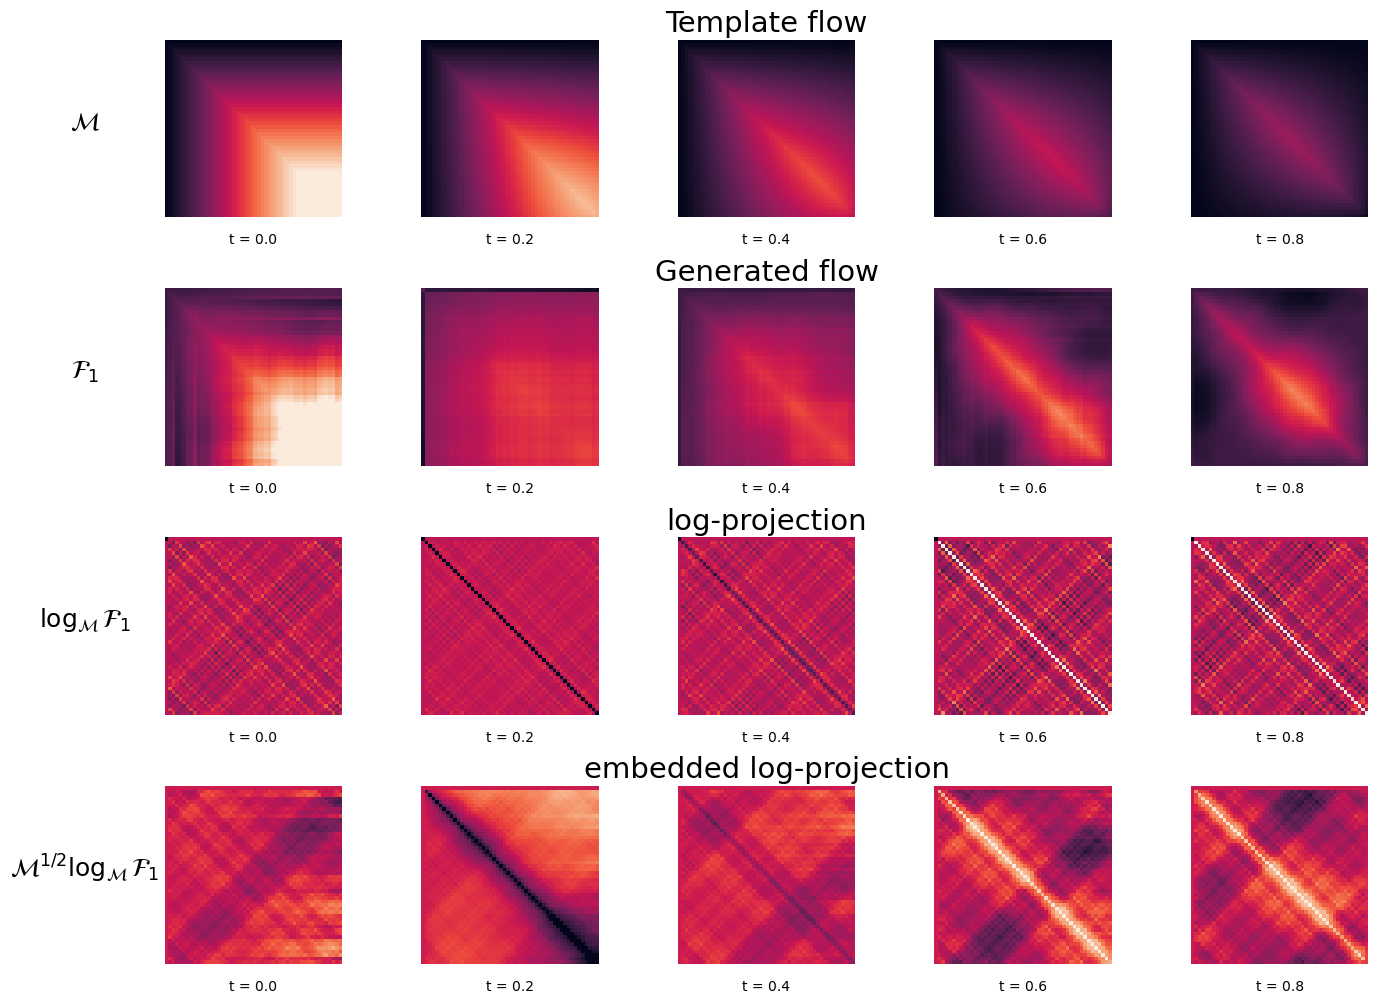

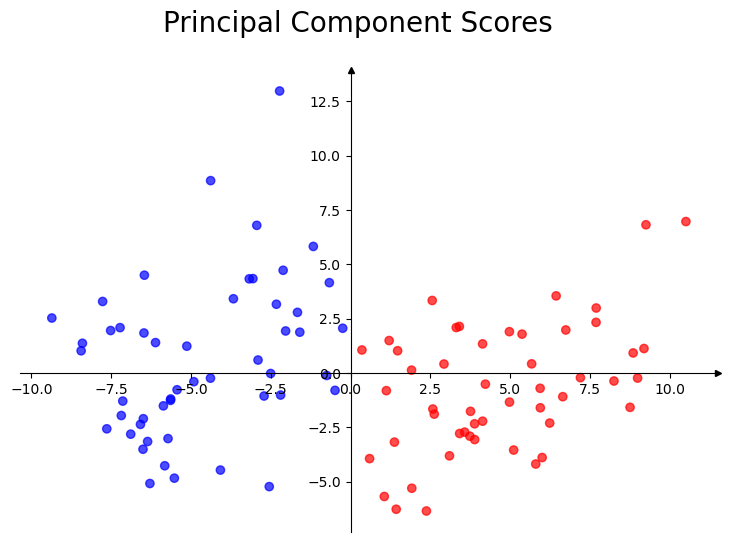

100%|█████████████████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


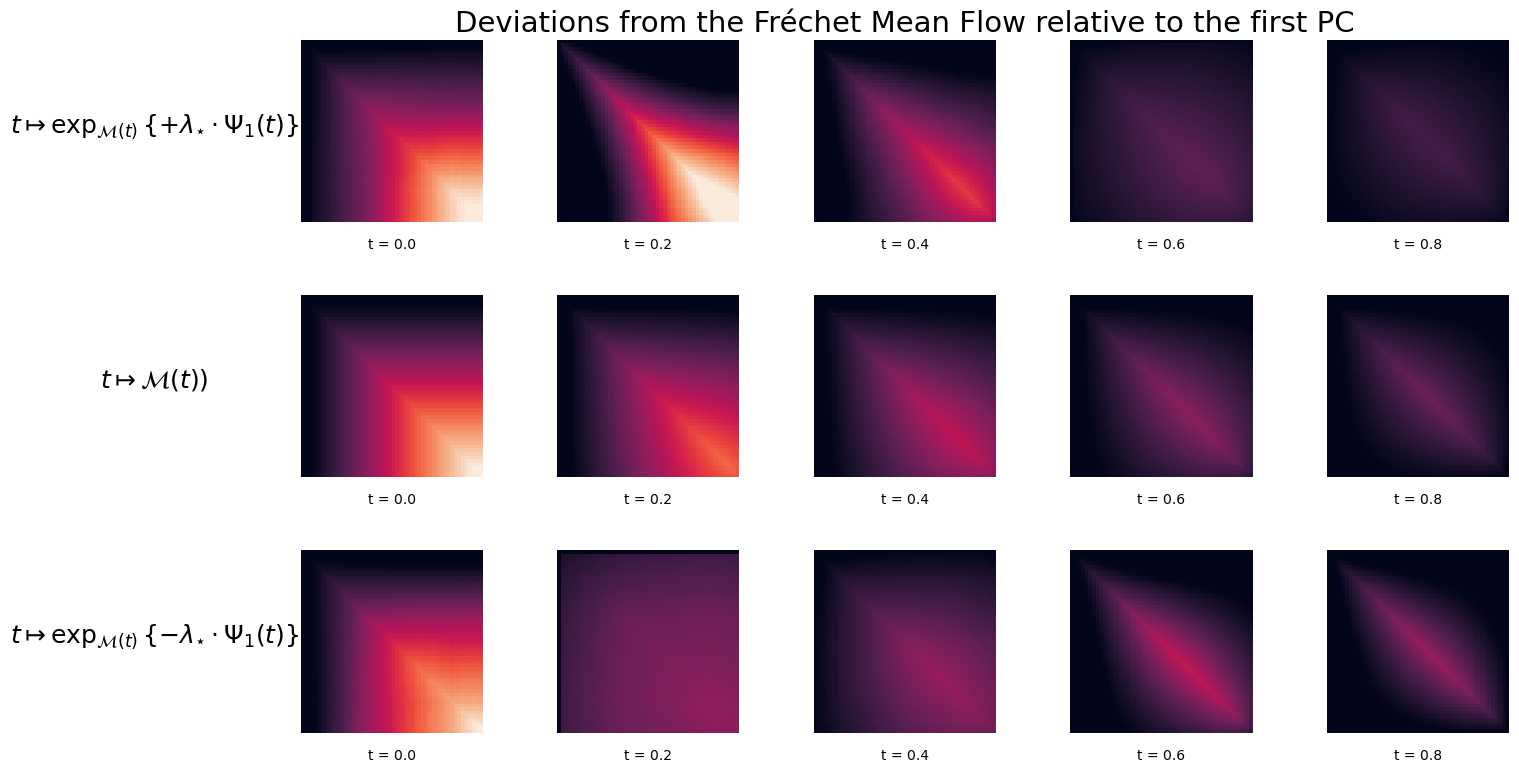

In [121]:
# dimension on Hilbert space -- corresponds to discretisation of eigenfunctions
d = 50;

# cutoff for Mercer's expansion
cutoff = d//2

# time discretisation of unit interval
N = 50; time_grid = np.linspace(0,1,N)

# for visualisation
tgrid_plot = 6

# number of samples
n = 100

tgrid_plot = 5

# pc__
ls = []
eps = 2*1e-1; ker = (signal.windows.hann(N)**(1/eps))[np.arange(-N//2,N//2)]; ker = ker/ker.sum()

K=25; ts = np.linspace(0,1,K); Y = np.zeros(K); Y[2*K//7]=1
Y_out =  np.real(ifft( fft(interp1d(ts, Y, kind='linear')(time_grid))*fft(ker) )); Y_out = Y_out/Y_out.max()*1.3
ls.append(Y_out)

K=12; ts = np.linspace(0,1,K); Y = np.zeros(K); Y[3*K//7]=1/3; Y[-K//3]=1
Y_out =  np.real(ifft( fft(interp1d(ts, Y, kind='linear')(time_grid))*fft(ker) ));  Y_out = Y_out/Y_out.max() 
ls.append(Y_out)


fig,[ax0,axR,axL] = plt.subplots(figsize = (15,3), ncols=3,sharey=False)
for iii,l in enumerate(ls):
    ax0.plot(time_grid,l, label ='$g_{}$'.format(iii+1));
ax0.set_title('$g_1(t)$ & $g_2(t)$' ,fontsize=14)
ax0.legend()

__pcs = np.array([ [uniform(-1,0) for i in range(n//2)] + [uniform(0,1) for i in range(n//2)], 
                   [uniform(0,1) for i in range(n//2)] + [uniform(-1,0) for i in range(n//2)] ]).T
lambdas_flows = np.array([ 1 +  (pc1*ls[0] + pc2*ls[1])/1.1 for (pc1,pc2) in __pcs])
for flow,c in zip(lambdas_flows, ['r' for i in range(n//2)]+['b' for i in range(n//2)]):
    axL.plot(time_grid,flow,alpha=.8, color = c)
axL.plot(time_grid,lambdas_flows.mean(0), lw=12,c='k',alpha=.4)

axR.scatter(__pcs[:,0],__pcs[:,1], c = (['r' for i in range(n//2)]+['b' for i in range(n//2)]), s = 10)
_val_x = 1.1*np.abs(__pcs[:,0]).max(); _val_y = 1.1*np.abs(__pcs[:,1]).max()
xmin, xmax, ymin, ymax = -_val_x, _val_x, -_val_y, _val_y; ticks_frequency = 1

axR.spines['bottom'].set_position('zero'); axR.spines['left'].set_position('zero')
axR.spines['top'].set_visible(False); axR.spines['right'].set_visible(False)
arrow_fmt = dict(markersize=4, color='black', clip_on=False)
axR.plot((1), (0), marker='>', transform=axR.get_yaxis_transform(), **arrow_fmt)
axR.plot((0), (1), marker='^', transform=axR.get_xaxis_transform(), **arrow_fmt)

axL.set_title('$\{W^{(i)}(t)\}_i$' ,fontsize=14)
axR.set_title('$\{(a^{(i)}_1,a^{(i)}_2)\}_i$', fontsize=14)
# fig.savefig("out/bimodal_params.png"); 
plt.show() 

# flows of transport maps generated randomly accoridng to a mean identity bimdodal law
Ts1 = np.array([FreqDom_GenModel_FLOW(N,d,cutoff,lambdas_flow =lambdas_flow, k=20 ) for lambdas_flow in lambdas_flows[:n//2] ])
Ts2 = np.array([FreqDom_GenModel_FLOW(N,d,cutoff, lambdas_flow =lambdas_flow , k=20) for lambdas_flow in lambdas_flows[n//2:] ])

# random samples obtained by perturbations of template flow by flows of transport maps generated randomly
cov0 =  BM_cov(d); cov1 = BB_cov(d); M = np.array([McCann(cov0,cov1)(t) for t in time_grid]).real

Xs1 = np.array([  np.array([T_@M_@T_ for M_,T_ in zip(M,T) ]) for  T in Ts1])
Xs2 = np.array([  np.array([T_@M_@T_ for M_,T_ in zip(M,T) ]) for  T in Ts2])
Xs = np.concatenate([Xs1,Xs2])

# embedd 
log = np.array([ np.array([optmap(M[t_ix], Xs[i,t_ix]) -  np.eye(d) for t_ix, t in enumerate(time_grid)]) for i in tqdm(np.arange(n))]).real
_embedded_log = np.array([ np.array([ _[t_ix]@sqrtm(M[t_ix]) for t_ix, t in enumerate(time_grid)]) for _ in log ]).real

suptitles = ['Template flow','Generated flow','log-projection', 'embedded log-projection']
titles = ['\mathcal{M}', '\mathcal{F}_1','\log_{\mathcal{M}}\mathcal{F}_1',
          '\mathcal{M}^{1/2}\log_{\mathcal{M}}\mathcal{F}_1']


ix = 1; Fs = [M,Xs[ix], log[ix], _embedded_log[ix]]
fig = plotFlow_heatmaps(Fs , tgrid_plot,cmap=cmap, suptitles = suptitles, titles = titles)
# fig.savefig("out/emblogflow_pca.png");
plt.show() 

# PCA
embedded_log = np.array([_.ravel() for _ in _embedded_log]).real
pca = PCA(n_components=2); data = embedded_log
PCscores = pca.fit_transform(data).T
_vectorised_PC = pca.components_ 
variance_explained = pca.explained_variance_ratio_ # print('respective % of explained variance: {}'.format(variance_explained.round(2) ))

n_components=2; n_clusters=2
c = np.array([ [['b','r', 'g' ,'c','y','m'][j] for i in range(n//n_clusters)] for j in range(n_clusters)] ).ravel() 
fig,ax=plt.subplots(figsize = (9,6))
ax.scatter(PCscores[0],PCscores[1], c=c,alpha=.7)
_val_x = 1.1*np.abs(PCscores[0]).max(); _val_y = 1.1*np.abs(PCscores[1]).max()
xmin, xmax, ymin, ymax = -_val_x, _val_x, -_val_y, _val_y; ticks_frequency = 1
ax.spines['bottom'].set_position('zero'); ax.spines['left'].set_position('zero')
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
arrow_fmt = dict(markersize=4, color='black', clip_on=False)
ax.plot((1), (0), marker='>', transform=ax.get_yaxis_transform(), **arrow_fmt)
ax.plot((0), (1), marker='^', transform=ax.get_xaxis_transform(), **arrow_fmt)
fig.suptitle('Principal Component Scores', fontsize = 20)
# fig.savefig("out/pcs.png"); 
plt.show() 

# these are elements in the embedded tangent space: i.e. (T -I)Xi^{1/2} 
PCs = np.array([_.reshape(_embedded_log.shape[1:]) for _ in _vectorised_PC])

# these are elements in the  tangent space: i.e. (T -I)
tanPCs = np.array([[_@inv(sqrtm(m + np.eye(d)*1e-10)) for _, m in zip(__, M)] for __ in PCs])

# make them self-adjoint
_tanPCs = np.array([[sqrtm((_+np.eye(d))@(_+np.eye(d)).T) - np.eye(d) for _ in __] for __ in tanPCs ])

lambdas = np.linspace(0,10,20) 
mineigs = np.array([np.linalg.eig(np.eye(d) + lam*_tanPCs[0]).eigenvalues.min() * 
                    np.linalg.eig(np.eye(d) - lam*_tanPCs[0]).eigenvalues.min()  for lam in lambdas])
LAM = lambdas[np.where(mineigs>0)][-2]
           

suptitles = ['Deviations from the Fréchet Mean Flow relative to the first PC','','']
titles = ['t\mapsto \exp_{\mathcal{M}(t)} \{+\lambda_{\star}\cdot\Psi_1(t)\}', 
          't\mapsto \mathcal{M}(t))', 't\mapsto \exp_{\mathcal{M}(t)} \{-\lambda_{\star}\cdot\Psi_1(t)\}']

ix = 4; Fs = [np.array([_@m@_ for m, _ in zip(M,np.eye(d) + LAM*_tanPCs[0]) ]),
             M,
             np.array([_@m@_ for m, _ in zip(M,np.eye(d) - LAM*_tanPCs[0]) ])]

fig = plotFlow_heatmaps(Fs , tgrid_plot,cmap=cmap, suptitles = suptitles, titles = titles,xtitle = -.8, vmin_=.05, vmax_ = .95)
# fig.savefig("out/pc_deviationFromMean.png");
plt.show() 